In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import ysnnutil as yut
nb='nb15'
wFile='./'+nb+'_fitSHYqp'

2023-06-13 06:54:33.270603: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-13 06:54:33.270668: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
### Magnesium alloy SHYqp model with q=14,p=13
deg,vCoeff=yut.getCoeff('./AZ31B_Lou2007_TXT2B_SHYqp_deg14_Err_and_Coeff.txt')
maxSXY=1.0/(np.sqrt(3.0)*(1.0+vCoeff[-1]))
nQ,nP=yut.nMonoms(deg)
ddMon=yut.vPoly(deg)

## Generate data
vPoints=yut.genSpherePoints(100,moreBiax=False)
nPoints=vPoints.shape[0]
print('Number of data points = ',nPoints)
rho=yut.fSHYqp(vPoints[:,0],vPoints[:,1],vPoints[:,2],vCoeff,ddMon,nQ,nP)
vPoints[:,0]=vPoints[:,0]/rho[:]
vPoints[:,1]=vPoints[:,1]/rho[:]
vPoints[:,2]=vPoints[:,2]/rho[:]

degQ =  14
Number of data points =  6512


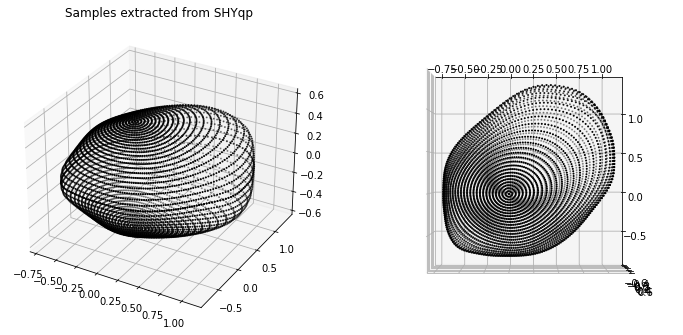

In [4]:
fg=plt.figure(figsize=(12,25))
axa=fg.add_subplot(1,2,1,projection='3d')
axa.scatter(vPoints[:,0],vPoints[:,1],vPoints[:,2],marker='o',color='k',s=1)
axa.set_title("Samples extracted from SHYqp")
axb=fg.add_subplot(1,2,2,projection='3d')
axb.scatter(vPoints[:,0],vPoints[:,1],vPoints[:,2],marker='o',color='k',s=1)
axb.azim=270;axb.elev=90
plt.show()

In [23]:
### Scramble the data and generate targets
np.random.seed(99)
pp=np.random.permutation(nPoints)
vPoints[:]=vPoints[pp[:]]
vTargets=np.ones((nPoints,1))

In [24]:
import os,random
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
gseed=99
np.random.seed(gseed)
random.seed(gseed)
os.environ['PYTHONHASHSEED']=str(gseed)

from keras import backend as K
if(1):
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    tf.random.set_seed(gseed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [35]:
def pwAct10(x):
    return (x**9)*tf.math.maximum(0.0,x)

opt=keras.optimizers.RMSprop(learning_rate=0.0001)
mmval=0.975  ;mmval=0.5
nun=60
model=keras.Sequential([
layers.Dense(nun,activation=pwAct10,use_bias=False,
             #kernel_initializer=keras.initializers.RandomUniform(minval=-mmval, maxval=mmval, seed=gseed),
             kernel_initializer=keras.initializers.GlorotUniform(gseed),
             kernel_regularizer=keras.regularizers.L2(l2=1e-6)),
layers.Dense(1,use_bias=False,
             kernel_constraint=keras.constraints.NonNeg(),
             kernel_initializer=keras.initializers.Ones(),
             #trainable=False
            )
])
model.compile(optimizer=opt,loss=keras.losses.MeanSquaredError(),metrics=["accuracy"])    
#keras.utils.set_random_seed(99)
np.random.seed(gseed)
random.seed(gseed)
tf.random.set_seed(gseed)
history=model.fit(
vPoints,
vTargets,
epochs=450,
batch_size=16,
#batch_size=nPoints,
validation_data=()
)

Epoch 1/450
407/407 [==============================] - 1s 1ms/step - loss: 0.9997 - accuracy: 0.0000e+00
Epoch 2/450
407/407 [==============================] - 1s 1ms/step - loss: 0.9993 - accuracy: 0.0000e+00
Epoch 3/450
407/407 [==============================] - 1s 1ms/step - loss: 0.9982 - accuracy: 0.0000e+00
Epoch 4/450
407/407 [==============================] - 1s 1ms/step - loss: 0.9959 - accuracy: 0.0000e+00
Epoch 5/450
407/407 [==============================] - 1s 1ms/step - loss: 0.9910 - accuracy: 0.0000e+00
Epoch 6/450
407/407 [==============================] - 1s 1ms/step - loss: 0.9822 - accuracy: 0.0000e+00
Epoch 7/450
407/407 [==============================] - 1s 1ms/step - loss: 0.9670 - accuracy: 0.0083
Epoch 8/450
407/407 [==============================] - 1s 1ms/step - loss: 0.9472 - accuracy: 0.0264
Epoch 9/450
407/407 [==============================] - 1s 1ms/step - loss: 0.9335 - accuracy: 0.0365
Epoch 10/450
407/407 [==============================] - 1s 1ms/step

i =  0  sxy =  0.0
i =  1  sxy =  0.10657174982499601
i =  2  sxy =  0.159857624737494
i =  3  sxy =  0.21314349964999202
i =  4  sxy =  0.26642937456249
i =  5  sxy =  0.319715249474988
i =  6  sxy =  0.37300112438748595
i =  7  sxy =  0.42628699929998404
i =  8  sxy =  0.479572874212482
i =  9  sxy =  0.5195372803968554
i =  10  sxy =  0.5275301616337302
i =  11  sxy =  0.5317930316267301


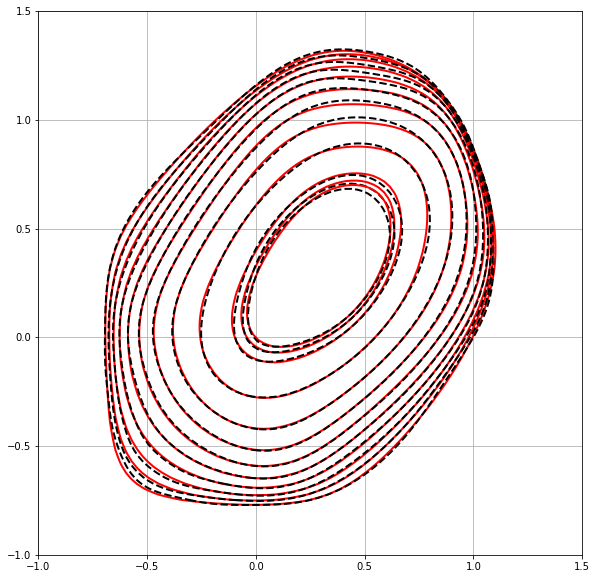

In [36]:
npt=100
vsx=np.linspace(-1.0,1.5,npt)
vsy=np.linspace(-1.0,1.5,npt)
###maxSXY=0.5
#vsxy=[0.0]
vsxy=maxSXY*np.array([0.0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.975,0.99,0.998])
X,Y=np.meshgrid(vsx,vsy)
npt2=npt*npt
X,Y=X.reshape((npt2,1)),Y.reshape((npt*npt,1))
vp=np.zeros((npt*npt,3))
vp[:,0]=X[:,0];vp[:,1]=Y[:,0]
vzPoly=np.zeros((npt2,1))
fg2=plt.figure(figsize=(10,10))
ax2=fg2.add_subplot()
for ii,sxy in enumerate(vsxy):
    vp[:,2]=sxy
    vz=model(vp)
    vzSHY=yut.fSHYqp(vp[:,0],vp[:,1],vp[:,2],vCoeff,ddMon,nQ,nP)
    print('i = ',ii, ' sxy = ',sxy)
    ax2.contour(vsx,vsy,tf.reshape(vz,(npt,npt)),levels=[1.0],linewidths=2,colors=['r'])
    ax2.contour(vsx,vsy,vzSHY.reshape((npt,npt)),levels=[1.0],linewidths=2,linestyles='--',colors=['k'])
    #vz2=vTerms[0]**(1.0/degree);print(np.max(vz-vz2),np.min(vz-vz2))
    #ax.contour(vsx,vsy,vz2,levels=[1.0],linewidths=1,colors=['r'])
ax2.grid()
ax2.set_aspect('equal')
plt.show()

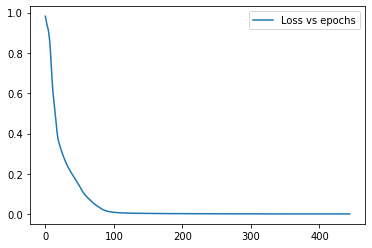

In [37]:
##print(len(history.history['loss']))
fhst=plt.figure()
ax=fhst.add_subplot()
ax.plot(history.history['loss'][5:], label='Loss vs epochs')
ax.legend()
plt.show()

In [38]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 60)                180       
                                                                 
 dense_11 (Dense)            (None, 1)                 60        
                                                                 
Total params: 240
Trainable params: 240
Non-trainable params: 0
_________________________________________________________________


In [39]:
vw=model.get_weights()
#dir(vw)
print('number of layers: ',len(vw))
print('first layer weight matrix: ',vw[0].shape)
print('second layer weight matrix: ',vw[1].shape)

number of layers:  2
first layer weight matrix:  (3, 60)
second layer weight matrix:  (60, 1)


In [40]:
model.save_weights(wFile, overwrite=True, save_format='tf', options=None)